In [1]:
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from importlib.util import find_spec
import sys

if find_spec("keras_unet") is None:
    sys.path.append('/scratch/cloned_repositories/keras-unet/')

import keras_unet
from keras_unet.utils import get_augmented
from keras_unet.models import custom_unet

from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from keras_unet.utils import plot_segm_history
from keras_unet.utils import plot_imgs

if find_spec("losses") is None:
    sys.path.append('..')
import losses

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
random_seed = 42

In [3]:
weights_dir = '/scratch/fibro_arrhythm_data/ds210320/weights'

In [4]:
image_filenames = glob.glob("/scratch/fibro_arrhythm_data/ds210320/textures/*.npy")
label_filenames = glob.glob("/scratch/fibro_arrhythm_data/ds210320/labels/*.npy")

image_filenames.sort()
label_filenames.sort()

In [5]:
images = []
labels = []

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image = np.load(image_filename)
    image = np.pad(image, (1, 1), 'constant')  # TODO: check this or avoid this by saving the data differently
    images.append(image)
    
    label = np.load(label_filename)
    label = np.pad(label, (1, 1), 'constant')
    labels.append(label)

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

print(images.min(), images.max(), "    ", labels.min(), labels.max())
print(images.shape, "    ", labels.shape)

0.0 1.0      0.0 1.0
(998, 256, 256, 1)      (998, 256, 256, 1)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=random_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111111, random_state=random_seed) # 0.111111 x 0.9 = 0.1

In [7]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (798, 256, 256, 1)
y_train:  (798, 256, 256, 1)
x_val:  (100, 256, 256, 1)
y_val:  (100, 256, 256, 1)
x_test:  (100, 256, 256, 1)
y_test:  (100, 256, 256, 1)


In [8]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [9]:
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [11]:
model_version = 'custom_unet_v0.0.0.1_ftloss'
callback_checkpoint = ModelCheckpoint(
    weights_dir + '/weights_' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.h5', 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=False,
)

In [12]:
def recall(y_true, y_pred):
    _, recall = losses.confusion(y_true, y_pred)
    return recall

In [13]:
model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss=losses.focal_tversky,
    #loss=jaccard_distance,
    metrics=[recall]
)

In [14]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=x_train.shape[0],
    epochs=25,    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)
model.save(weights_dir + '/' + model_version + '.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 798 steps, validate on 100 samples
Epoch 1/25
797/798 [============================>.] - ETA: 1s - loss: 0.9410 - recall: 0.9917
Epoch 00001: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.1_ftloss/weights.01-0.95.h5
798/798 [==============================] - 1381s 2s/step - loss: 0.9410 - recall: 0.9917 - val_loss: 0.9486 - val_recall: 1.0000
Epoch 2/25
797/798 [============================>.] - ETA: 1s - loss: 0.9410 - recall: 1.0000
Epoch 00002: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.1_ftloss/weights.02-0.95.h5
798/798 [==============================] - 1383s 2s/step - loss: 0.9411 - recall: 1.0000 - val_loss: 0.9486 - val_recall: 1.0000
Epoch 3/25
797/798 [============================>.] - ETA: 1s - loss: 0.9410 - recall: 1.0000
Epoch 00003: saving model to /scratch/fibro_arrhythm_d

797/798 [============================>.] - ETA: 1s - loss: 0.9412 - recall: 1.0000
Epoch 00023: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.1_ftloss/weights.23-0.95.h5
798/798 [==============================] - 1409s 2s/step - loss: 0.9411 - recall: 1.0000 - val_loss: 0.9486 - val_recall: 1.0000
Epoch 24/25
797/798 [============================>.] - ETA: 1s - loss: 0.9411 - recall: 1.0000
Epoch 00024: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.1_ftloss/weights.24-0.95.h5
798/798 [==============================] - 1412s 2s/step - loss: 0.9411 - recall: 1.0000 - val_loss: 0.9486 - val_recall: 1.0000
Epoch 25/25
797/798 [============================>.] - ETA: 1s - loss: 0.9412 - recall: 1.0000
Epoch 00025: saving model to /scratch/fibro_arrhythm_data/ds210320/weights/weights_custom_unet_v0.0.0.1_ftloss/weights.25-0.95.h5
798/798 [==============================] - 1418s 2s/step - loss: 0.9411 - recal

In [15]:
history.history

{'loss': [0.9409551094647935,
  0.9410706392505712,
  0.9410482907952521,
  0.9410271047798912,
  0.9410212257302794,
  0.9409585988760593,
  0.9411302030385288,
  0.940918858562197,
  0.941070733886016,
  0.9409203933444537,
  0.9409699534115038,
  0.9411227020404691,
  0.9409322979157431,
  0.9411845056335431,
  0.9409644765065128,
  0.9409276840830207,
  0.9412278288737276,
  0.9408892873385197,
  0.9410554194510132,
  0.9412057186129099,
  0.9409487409549847,
  0.9412234594349873,
  0.9411051855200813,
  0.9411011214991262,
  0.9410989085833231],
 'recall': [0.9917376,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777497291565,
  0.9485777485370636,
  0.948577748537063

In [ ]:
plot_segm_history(history)

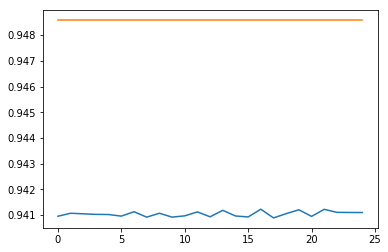

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
# model.load_weights(weights_dir + '/' + model_version + '.h5')

In [23]:
segm_beg = 10
segm_eng = 30
x_test_segment = x_test[segm_beg:segm_eng]
y_test_segment = y_test[segm_beg:segm_eng]
y_pred = model.predict(x_test_segment)

In [24]:
print(x_test_segment.shape)
print(y_test_segment.shape)
print(y_pred.shape)

(20, 256, 256, 1)
(20, 256, 256, 1)
(20, 256, 256, 1)


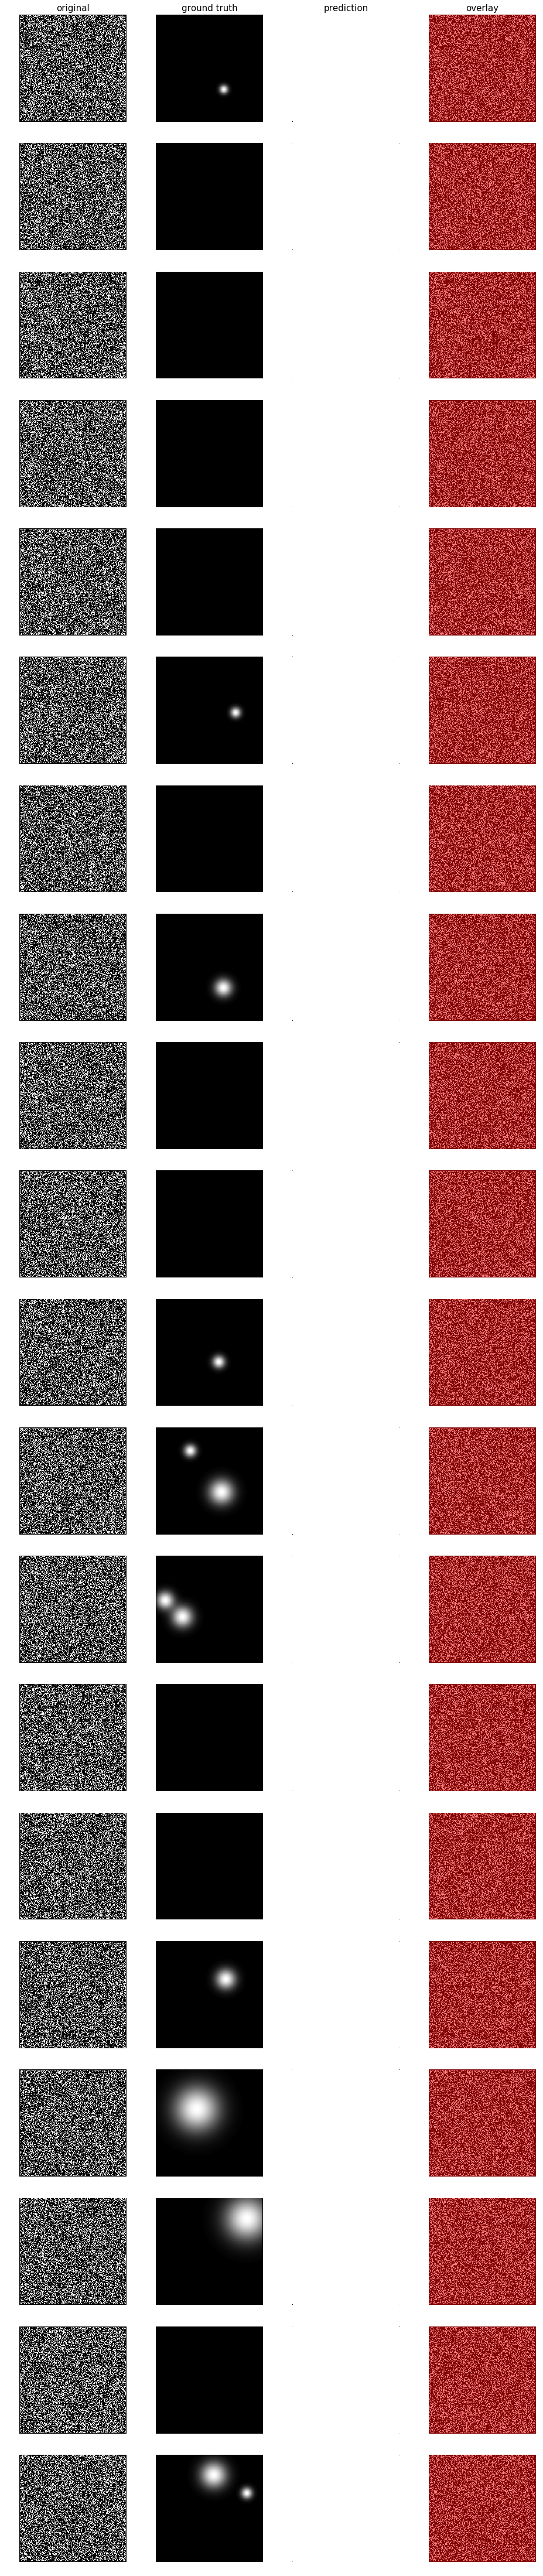

In [25]:
plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=20)

In [27]:
temp = y_pred[5,:,:,0]
print(temp.shape)

(256, 256)


In [32]:
print(np.min(temp), np.max(temp))

0.9845856 1.0
